## Entanglement in the H$_2$ molecule

With RBM we can access with a fairly good approximation to the coefficients of the state corresponding to sample measures. We can use [QuCumber](https://github.com/PIQuIL/QuCumber) for this. Many things can be done with the exact coefficients, but we will focus on the entanglement between the two atoms. There is interest in measuring this quantity beacause it is a resource in quantum information protocols.

A disclaimer has to be made, as these particles are indistinguishable and have some spetial properties. A more "fermionic" treatment requires antisymmetrization and more advanced concepts [[1](https://arxiv.org/pdf/quant-ph/0203060.pdf)]. We would be neglecting this fermionic behavior and treat the atoms as distinguishable sytems. 

Alice and Bob will be now the two atoms. A measure would return 0 when an electron is located in the first orbital 1s, and 1 when it is in the 2p orbital. In that case, entanglement is obtained with the Von Neumann entropy $S(\rho)=-\sum_i \lambda_i \log(\lambda_i)$ where $\lambda_i$ are the eigenvalues of the reduced density matrix corresponding to a subsystem.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWaveFunction
from qucumber.callbacks import MetricEvaluator
import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

# set random seed on cpu but not gpu, since we won't use gpu for this tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)

In [4]:
nv = 2
nh = 10

nn_state = PositiveWaveFunction(num_visible=nv, num_hidden=nh, gpu=False)
epochs = 200
pbs = 100
nbs = pbs
lr = 0.01
k = 10

period = 10
space = nn_state.generate_hilbert_space()

def psi_coefficient0(nn_state, space, A, **kwargs):
    norm = nn_state.compute_normalization(space).sqrt_()
    return A * nn_state.psi(space)[0][0] / norm
def psi_coefficient1(nn_state, space, A, **kwargs):
    norm = nn_state.compute_normalization(space).sqrt_()
    return A * nn_state.psi(space)[0][1] / norm
def psi_coefficient2(nn_state, space, A, **kwargs):
    norm = nn_state.compute_normalization(space).sqrt_()
    return A * nn_state.psi(space)[0][2] / norm
def psi_coefficient3(nn_state, space, A, **kwargs):
    norm = nn_state.compute_normalization(space).sqrt_()
    return A * nn_state.psi(space)[0][3] / norm

#size subsystem A
n = 2
#size subsystem B
m = 2

entanglement = np.zeros(53)

for i in range(53):
    if i % 2 == 0:
        R_i = round(0.2 + 0.05*i, 2)
    else:
        R_i = round(0.2 + 0.05*i, 1)
    train_path = f"H2_data/R_{(R_i)}_samples.txt"
    train_data = data.load_data(train_path)[0]
    
    callbacks = [
        MetricEvaluator(
            period,
            {"A_Ψrbm_0": psi_coefficient0,"A_Ψrbm_1": psi_coefficient1,"A_Ψrbm_2": psi_coefficient2,"A_Ψrbm_3": psi_coefficient3},
            verbose=True,
            space=space,
            A=1.0,
        )
    ]

    nn_state.fit(
        train_data,
        epochs=epochs,
        pos_batch_size=pbs,
        neg_batch_size=nbs,
        lr=lr,
        k=k,
        callbacks=callbacks,
        time=True,
    )
   
    coeffs = np.array([callbacks[0]["A_Ψrbm_0"][-1],callbacks[0]["A_Ψrbm_1"][-1],callbacks[0]["A_Ψrbm_2"][-1],callbacks[0]["A_Ψrbm_3"][-1]])
    rho = coeffs*coeffs.reshape((4,1))
    rho_A = np.trace(rho.reshape(n,m,n,m), axis1=0, axis2=2)
    eigen = np.linalg.eig(rho_A)[0]
    entanglement[i] = -sum(eigen*(np.log2(eigen)))

Epoch: 10	A_Ψrbm_0 = 0.130702	A_Ψrbm_1 = 0.030507	A_Ψrbm_2 = 0.979269	A_Ψrbm_3 = 0.151718
Epoch: 20	A_Ψrbm_0 = 0.089495	A_Ψrbm_1 = 0.015877	A_Ψrbm_2 = 0.990403	A_Ψrbm_3 = 0.104118
Epoch: 30	A_Ψrbm_0 = 0.074056	A_Ψrbm_1 = 0.011475	A_Ψrbm_2 = 0.993499	A_Ψrbm_3 = 0.085700
Epoch: 40	A_Ψrbm_0 = 0.064854	A_Ψrbm_1 = 0.009120	A_Ψrbm_2 = 0.995082	A_Ψrbm_3 = 0.074310
Epoch: 50	A_Ψrbm_0 = 0.059155	A_Ψrbm_1 = 0.007788	A_Ψrbm_2 = 0.995948	A_Ψrbm_3 = 0.067291
Epoch: 60	A_Ψrbm_0 = 0.054949	A_Ψrbm_1 = 0.006871	A_Ψrbm_2 = 0.996529	A_Ψrbm_3 = 0.062160
Epoch: 70	A_Ψrbm_0 = 0.051670	A_Ψrbm_1 = 0.006193	A_Ψrbm_2 = 0.996949	A_Ψrbm_3 = 0.058172
Epoch: 80	A_Ψrbm_0 = 0.048978	A_Ψrbm_1 = 0.005666	A_Ψrbm_2 = 0.997269	A_Ψrbm_3 = 0.054979
Epoch: 90	A_Ψrbm_0 = 0.047138	A_Ψrbm_1 = 0.005297	A_Ψrbm_2 = 0.997495	A_Ψrbm_3 = 0.052470
Epoch: 100	A_Ψrbm_0 = 0.045557	A_Ψrbm_1 = 0.005001	A_Ψrbm_2 = 0.997673	A_Ψrbm_3 = 0.050476
Epoch: 110	A_Ψrbm_0 = 0.044052	A_Ψrbm_1 = 0.004735	A_Ψrbm_2 = 0.997830	A_Ψrbm_3 = 0.048702
Epoch: 1

Epoch: 100	A_Ψrbm_0 = 0.054087	A_Ψrbm_1 = 0.008196	A_Ψrbm_2 = 0.997294	A_Ψrbm_3 = 0.049111
Epoch: 110	A_Ψrbm_0 = 0.053802	A_Ψrbm_1 = 0.008225	A_Ψrbm_2 = 0.997306	A_Ψrbm_3 = 0.049186
Epoch: 120	A_Ψrbm_0 = 0.053420	A_Ψrbm_1 = 0.008218	A_Ψrbm_2 = 0.997331	A_Ψrbm_3 = 0.049081
Epoch: 130	A_Ψrbm_0 = 0.053524	A_Ψrbm_1 = 0.008306	A_Ψrbm_2 = 0.997319	A_Ψrbm_3 = 0.049202
Epoch: 140	A_Ψrbm_0 = 0.053599	A_Ψrbm_1 = 0.008381	A_Ψrbm_2 = 0.997312	A_Ψrbm_3 = 0.049243
Epoch: 150	A_Ψrbm_0 = 0.053790	A_Ψrbm_1 = 0.008486	A_Ψrbm_2 = 0.997294	A_Ψrbm_3 = 0.049386
Epoch: 160	A_Ψrbm_0 = 0.054085	A_Ψrbm_1 = 0.008625	A_Ψrbm_2 = 0.997263	A_Ψrbm_3 = 0.049664
Epoch: 170	A_Ψrbm_0 = 0.054417	A_Ψrbm_1 = 0.008739	A_Ψrbm_2 = 0.997242	A_Ψrbm_3 = 0.049708
Epoch: 180	A_Ψrbm_0 = 0.054572	A_Ψrbm_1 = 0.008807	A_Ψrbm_2 = 0.997239	A_Ψrbm_3 = 0.049584
Epoch: 190	A_Ψrbm_0 = 0.054516	A_Ψrbm_1 = 0.008870	A_Ψrbm_2 = 0.997239	A_Ψrbm_3 = 0.049634
Epoch: 200	A_Ψrbm_0 = 0.054298	A_Ψrbm_1 = 0.008906	A_Ψrbm_2 = 0.997250	A_Ψrbm_3 = 0.049647

Epoch: 190	A_Ψrbm_0 = 0.065845	A_Ψrbm_1 = 0.049217	A_Ψrbm_2 = 0.994469	A_Ψrbm_3 = 0.065372
Epoch: 200	A_Ψrbm_0 = 0.064888	A_Ψrbm_1 = 0.049276	A_Ψrbm_2 = 0.994584	A_Ψrbm_3 = 0.064534
Total time elapsed during training: 67.959 s
Epoch: 10	A_Ψrbm_0 = 0.068391	A_Ψrbm_1 = 0.054955	A_Ψrbm_2 = 0.993849	A_Ψrbm_3 = 0.067570
Epoch: 20	A_Ψrbm_0 = 0.071043	A_Ψrbm_1 = 0.059895	A_Ψrbm_2 = 0.993220	A_Ψrbm_3 = 0.069854
Epoch: 30	A_Ψrbm_0 = 0.070690	A_Ψrbm_1 = 0.061121	A_Ψrbm_2 = 0.993192	A_Ψrbm_3 = 0.069551
Epoch: 40	A_Ψrbm_0 = 0.071388	A_Ψrbm_1 = 0.064077	A_Ψrbm_2 = 0.992894	A_Ψrbm_3 = 0.070426
Epoch: 50	A_Ψrbm_0 = 0.071145	A_Ψrbm_1 = 0.065532	A_Ψrbm_2 = 0.992840	A_Ψrbm_3 = 0.070084
Epoch: 60	A_Ψrbm_0 = 0.069604	A_Ψrbm_1 = 0.065674	A_Ψrbm_2 = 0.992997	A_Ψrbm_3 = 0.069279
Epoch: 70	A_Ψrbm_0 = 0.069381	A_Ψrbm_1 = 0.066937	A_Ψrbm_2 = 0.992966	A_Ψrbm_3 = 0.068732
Epoch: 80	A_Ψrbm_0 = 0.068697	A_Ψrbm_1 = 0.067647	A_Ψrbm_2 = 0.993022	A_Ψrbm_3 = 0.067907
Epoch: 90	A_Ψrbm_0 = 0.067109	A_Ψrbm_1 = 0.067334	A_Ψ

Epoch: 160	A_Ψrbm_0 = 0.028403	A_Ψrbm_1 = 0.201594	A_Ψrbm_2 = 0.978642	A_Ψrbm_3 = 0.028532
Epoch: 170	A_Ψrbm_0 = 0.027982	A_Ψrbm_1 = 0.198315	A_Ψrbm_2 = 0.979334	A_Ψrbm_3 = 0.028151
Epoch: 180	A_Ψrbm_0 = 0.027481	A_Ψrbm_1 = 0.194118	A_Ψrbm_2 = 0.980202	A_Ψrbm_3 = 0.027679
Epoch: 190	A_Ψrbm_0 = 0.027223	A_Ψrbm_1 = 0.193475	A_Ψrbm_2 = 0.980342	A_Ψrbm_3 = 0.027502
Epoch: 200	A_Ψrbm_0 = 0.026746	A_Ψrbm_1 = 0.188702	A_Ψrbm_2 = 0.981300	A_Ψrbm_3 = 0.026946
Total time elapsed during training: 67.159 s
Epoch: 10	A_Ψrbm_0 = 0.026729	A_Ψrbm_1 = 0.190178	A_Ψrbm_2 = 0.981016	A_Ψrbm_3 = 0.026949
Epoch: 20	A_Ψrbm_0 = 0.026729	A_Ψrbm_1 = 0.191503	A_Ψrbm_2 = 0.980757	A_Ψrbm_3 = 0.026971
Epoch: 30	A_Ψrbm_0 = 0.026830	A_Ψrbm_1 = 0.194712	A_Ψrbm_2 = 0.980118	A_Ψrbm_3 = 0.027144
Epoch: 40	A_Ψrbm_0 = 0.026965	A_Ψrbm_1 = 0.197595	A_Ψrbm_2 = 0.979534	A_Ψrbm_3 = 0.027232
Epoch: 50	A_Ψrbm_0 = 0.026690	A_Ψrbm_1 = 0.196266	A_Ψrbm_2 = 0.979815	A_Ψrbm_3 = 0.027022
Epoch: 60	A_Ψrbm_0 = 0.026557	A_Ψrbm_1 = 0.196341	

Epoch: 40	A_Ψrbm_0 = 0.022913	A_Ψrbm_1 = 0.262261	A_Ψrbm_2 = 0.964449	A_Ψrbm_3 = 0.023083
Epoch: 50	A_Ψrbm_0 = 0.022893	A_Ψrbm_1 = 0.263777	A_Ψrbm_2 = 0.964036	A_Ψrbm_3 = 0.023078
Epoch: 60	A_Ψrbm_0 = 0.022816	A_Ψrbm_1 = 0.264158	A_Ψrbm_2 = 0.963935	A_Ψrbm_3 = 0.022989
Epoch: 70	A_Ψrbm_0 = 0.022761	A_Ψrbm_1 = 0.265268	A_Ψrbm_2 = 0.963633	A_Ψrbm_3 = 0.022956
Epoch: 80	A_Ψrbm_0 = 0.022745	A_Ψrbm_1 = 0.266744	A_Ψrbm_2 = 0.963226	A_Ψrbm_3 = 0.022955
Epoch: 90	A_Ψrbm_0 = 0.022778	A_Ψrbm_1 = 0.269904	A_Ψrbm_2 = 0.962342	A_Ψrbm_3 = 0.023063
Epoch: 100	A_Ψrbm_0 = 0.022804	A_Ψrbm_1 = 0.272391	A_Ψrbm_2 = 0.961638	A_Ψrbm_3 = 0.023133
Epoch: 110	A_Ψrbm_0 = 0.022528	A_Ψrbm_1 = 0.267480	A_Ψrbm_2 = 0.963031	A_Ψrbm_3 = 0.022775
Epoch: 120	A_Ψrbm_0 = 0.022528	A_Ψrbm_1 = 0.269189	A_Ψrbm_2 = 0.962555	A_Ψrbm_3 = 0.022772
Epoch: 130	A_Ψrbm_0 = 0.022320	A_Ψrbm_1 = 0.265933	A_Ψrbm_2 = 0.963470	A_Ψrbm_3 = 0.022511
Epoch: 140	A_Ψrbm_0 = 0.022199	A_Ψrbm_1 = 0.264942	A_Ψrbm_2 = 0.963749	A_Ψrbm_3 = 0.022372
Epoch

Epoch: 130	A_Ψrbm_0 = 0.020717	A_Ψrbm_1 = 0.371423	A_Ψrbm_2 = 0.928000	A_Ψrbm_3 = 0.020765
Epoch: 140	A_Ψrbm_0 = 0.020467	A_Ψrbm_1 = 0.364576	A_Ψrbm_2 = 0.930723	A_Ψrbm_3 = 0.020505
Epoch: 150	A_Ψrbm_0 = 0.020390	A_Ψrbm_1 = 0.363368	A_Ψrbm_2 = 0.931199	A_Ψrbm_3 = 0.020401
Epoch: 160	A_Ψrbm_0 = 0.020198	A_Ψrbm_1 = 0.359051	A_Ψrbm_2 = 0.932880	A_Ψrbm_3 = 0.020222
Epoch: 170	A_Ψrbm_0 = 0.020240	A_Ψrbm_1 = 0.362255	A_Ψrbm_2 = 0.931639	A_Ψrbm_3 = 0.020244
Epoch: 180	A_Ψrbm_0 = 0.020307	A_Ψrbm_1 = 0.365681	A_Ψrbm_2 = 0.930298	A_Ψrbm_3 = 0.020267
Epoch: 190	A_Ψrbm_0 = 0.020023	A_Ψrbm_1 = 0.357054	A_Ψrbm_2 = 0.933656	A_Ψrbm_3 = 0.019941
Epoch: 200	A_Ψrbm_0 = 0.019981	A_Ψrbm_1 = 0.357935	A_Ψrbm_2 = 0.933320	A_Ψrbm_3 = 0.019917
Total time elapsed during training: 63.751 s
Epoch: 10	A_Ψrbm_0 = 0.020092	A_Ψrbm_1 = 0.363701	A_Ψrbm_2 = 0.931084	A_Ψrbm_3 = 0.020018
Epoch: 20	A_Ψrbm_0 = 0.019993	A_Ψrbm_1 = 0.363045	A_Ψrbm_2 = 0.931343	A_Ψrbm_3 = 0.019965
Epoch: 30	A_Ψrbm_0 = 0.020290	A_Ψrbm_1 = 0.3753

Epoch: 10	A_Ψrbm_0 = 0.017706	A_Ψrbm_1 = 0.428018	A_Ψrbm_2 = 0.903427	A_Ψrbm_3 = 0.017543
Epoch: 20	A_Ψrbm_0 = 0.017857	A_Ψrbm_1 = 0.438533	A_Ψrbm_2 = 0.898363	A_Ψrbm_3 = 0.017729
Epoch: 30	A_Ψrbm_0 = 0.017923	A_Ψrbm_1 = 0.444234	A_Ψrbm_2 = 0.895555	A_Ψrbm_3 = 0.017798
Epoch: 40	A_Ψrbm_0 = 0.017946	A_Ψrbm_1 = 0.448179	A_Ψrbm_2 = 0.893586	A_Ψrbm_3 = 0.017835
Epoch: 50	A_Ψrbm_0 = 0.017922	A_Ψrbm_1 = 0.449155	A_Ψrbm_2 = 0.893096	A_Ψrbm_3 = 0.017804
Epoch: 60	A_Ψrbm_0 = 0.017967	A_Ψrbm_1 = 0.453173	A_Ψrbm_2 = 0.891063	A_Ψrbm_3 = 0.017825
Epoch: 70	A_Ψrbm_0 = 0.018039	A_Ψrbm_1 = 0.459976	A_Ψrbm_2 = 0.887567	A_Ψrbm_3 = 0.017921
Epoch: 80	A_Ψrbm_0 = 0.018032	A_Ψrbm_1 = 0.462295	A_Ψrbm_2 = 0.886362	A_Ψrbm_3 = 0.017912
Epoch: 90	A_Ψrbm_0 = 0.018094	A_Ψrbm_1 = 0.468361	A_Ψrbm_2 = 0.883169	A_Ψrbm_3 = 0.017993
Epoch: 100	A_Ψrbm_0 = 0.018032	A_Ψrbm_1 = 0.465944	A_Ψrbm_2 = 0.884450	A_Ψrbm_3 = 0.017890
Epoch: 110	A_Ψrbm_0 = 0.018044	A_Ψrbm_1 = 0.468631	A_Ψrbm_2 = 0.883029	A_Ψrbm_3 = 0.017886
Epoch: 1

Epoch: 100	A_Ψrbm_0 = 0.015684	A_Ψrbm_1 = 0.506896	A_Ψrbm_2 = 0.861719	A_Ψrbm_3 = 0.015833
Epoch: 110	A_Ψrbm_0 = 0.015627	A_Ψrbm_1 = 0.504899	A_Ψrbm_2 = 0.862893	A_Ψrbm_3 = 0.015773
Epoch: 120	A_Ψrbm_0 = 0.015428	A_Ψrbm_1 = 0.492635	A_Ψrbm_2 = 0.869960	A_Ψrbm_3 = 0.015562
Epoch: 130	A_Ψrbm_0 = 0.015388	A_Ψrbm_1 = 0.493435	A_Ψrbm_2 = 0.869507	A_Ψrbm_3 = 0.015554
Epoch: 140	A_Ψrbm_0 = 0.015341	A_Ψrbm_1 = 0.492040	A_Ψrbm_2 = 0.870299	A_Ψrbm_3 = 0.015508
Epoch: 150	A_Ψrbm_0 = 0.015367	A_Ψrbm_1 = 0.494324	A_Ψrbm_2 = 0.869004	A_Ψrbm_3 = 0.015502
Epoch: 160	A_Ψrbm_0 = 0.015419	A_Ψrbm_1 = 0.500516	A_Ψrbm_2 = 0.865450	A_Ψrbm_3 = 0.015579
Epoch: 170	A_Ψrbm_0 = 0.015398	A_Ψrbm_1 = 0.500458	A_Ψrbm_2 = 0.865484	A_Ψrbm_3 = 0.015531
Epoch: 180	A_Ψrbm_0 = 0.015343	A_Ψrbm_1 = 0.499191	A_Ψrbm_2 = 0.866218	A_Ψrbm_3 = 0.015484
Epoch: 190	A_Ψrbm_0 = 0.015378	A_Ψrbm_1 = 0.503515	A_Ψrbm_2 = 0.863710	A_Ψrbm_3 = 0.015523
Epoch: 200	A_Ψrbm_0 = 0.015376	A_Ψrbm_1 = 0.506568	A_Ψrbm_2 = 0.861923	A_Ψrbm_3 = 0.015555

Epoch: 190	A_Ψrbm_0 = 0.014312	A_Ψrbm_1 = 0.598039	A_Ψrbm_2 = 0.801205	A_Ψrbm_3 = 0.014639
Epoch: 200	A_Ψrbm_0 = 0.014235	A_Ψrbm_1 = 0.591215	A_Ψrbm_2 = 0.806257	A_Ψrbm_3 = 0.014547
Total time elapsed during training: 48.770 s
Epoch: 10	A_Ψrbm_0 = 0.014274	A_Ψrbm_1 = 0.596893	A_Ψrbm_2 = 0.802062	A_Ψrbm_3 = 0.014571
Epoch: 20	A_Ψrbm_0 = 0.014230	A_Ψrbm_1 = 0.593588	A_Ψrbm_2 = 0.804512	A_Ψrbm_3 = 0.014514
Epoch: 30	A_Ψrbm_0 = 0.014201	A_Ψrbm_1 = 0.592778	A_Ψrbm_2 = 0.805111	A_Ψrbm_3 = 0.014472
Epoch: 40	A_Ψrbm_0 = 0.014179	A_Ψrbm_1 = 0.592952	A_Ψrbm_2 = 0.804983	A_Ψrbm_3 = 0.014449
Epoch: 50	A_Ψrbm_0 = 0.014173	A_Ψrbm_1 = 0.593786	A_Ψrbm_2 = 0.804369	A_Ψrbm_3 = 0.014419
Epoch: 60	A_Ψrbm_0 = 0.014145	A_Ψrbm_1 = 0.593141	A_Ψrbm_2 = 0.804845	A_Ψrbm_3 = 0.014396
Epoch: 70	A_Ψrbm_0 = 0.014140	A_Ψrbm_1 = 0.594284	A_Ψrbm_2 = 0.804002	A_Ψrbm_3 = 0.014372
Epoch: 80	A_Ψrbm_0 = 0.014136	A_Ψrbm_1 = 0.596736	A_Ψrbm_2 = 0.802185	A_Ψrbm_3 = 0.014373
Epoch: 90	A_Ψrbm_0 = 0.014037	A_Ψrbm_1 = 0.589084	A_Ψ

Epoch: 160	A_Ψrbm_0 = 0.011751	A_Ψrbm_1 = 0.657760	A_Ψrbm_2 = 0.753042	A_Ψrbm_3 = 0.011890
Epoch: 170	A_Ψrbm_0 = 0.011712	A_Ψrbm_1 = 0.651329	A_Ψrbm_2 = 0.758613	A_Ψrbm_3 = 0.011838
Epoch: 180	A_Ψrbm_0 = 0.011701	A_Ψrbm_1 = 0.651678	A_Ψrbm_2 = 0.758313	A_Ψrbm_3 = 0.011827
Epoch: 190	A_Ψrbm_0 = 0.011687	A_Ψrbm_1 = 0.652649	A_Ψrbm_2 = 0.757478	A_Ψrbm_3 = 0.011825
Epoch: 200	A_Ψrbm_0 = 0.011697	A_Ψrbm_1 = 0.658932	A_Ψrbm_2 = 0.752018	A_Ψrbm_3 = 0.011862
Total time elapsed during training: 44.679 s
Epoch: 10	A_Ψrbm_0 = 0.011701	A_Ψrbm_1 = 0.661224	A_Ψrbm_2 = 0.750004	A_Ψrbm_3 = 0.011854
Epoch: 20	A_Ψrbm_0 = 0.011706	A_Ψrbm_1 = 0.664896	A_Ψrbm_2 = 0.746750	A_Ψrbm_3 = 0.011863
Epoch: 30	A_Ψrbm_0 = 0.011692	A_Ψrbm_1 = 0.665188	A_Ψrbm_2 = 0.746490	A_Ψrbm_3 = 0.011853
Epoch: 40	A_Ψrbm_0 = 0.011650	A_Ψrbm_1 = 0.659881	A_Ψrbm_2 = 0.751187	A_Ψrbm_3 = 0.011811
Epoch: 50	A_Ψrbm_0 = 0.011635	A_Ψrbm_1 = 0.659095	A_Ψrbm_2 = 0.751877	A_Ψrbm_3 = 0.011789
Epoch: 60	A_Ψrbm_0 = 0.011653	A_Ψrbm_1 = 0.664513	

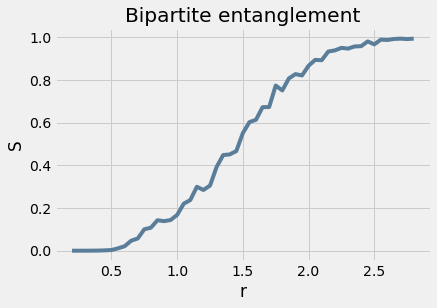

In [5]:
plt.style.use('fivethirtyeight')

plt.plot(np.arange(0.2,2.85,0.05).reshape(-1,1),entanglement, color='#5a7d9a')

plt.xlabel('r')
plt.ylabel('S')
plt.title('Bipartite entanglement')


plt.grid(True)

 We can see that entanglement grows with the interatomic distance. In this limit, atoms exist in a separable state.  A possible explanation is that for short distances, electrons tend to interact more with both nuclei. This would strongly correlate the electrons with the nuclei, reducing the correlations between the different electrons because of monotony. As distance grows they can become more correlated. This behavior must be reviewed in a fully indistiguishable picture.